# Import relevant libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Data Preparation

In [2]:
# Define direktory
train_dir = '../input/labeled-chest-xray-images/chest_xray/train'
val_dir = '../input/labeled-chest-xray-images/chest_xray/test'

In [3]:
# Visualize Image before Image Augmentation
train_pneumonia_img = glob(train_dir+'/PNEUMONIA/*.jpeg') # Load all pneumonia images from train directory
train_normal_img = glob(train_dir+'/NORMAL/*.jpeg') # Load all normal images frin train directory

In [4]:
pneumonia = np.asarray(plt.imread(train_pneumonia_img[0]))
normal = np.asarray(plt.imread(train_normal_img[0]))

(1032, 1528)


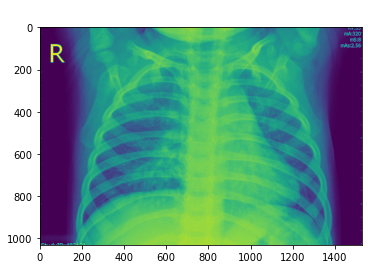

In [5]:
plt.title('PNEUMONIA', fontsize=20, color='white')
plt.imshow(pneumonia)
print(pneumonia.shape) # print image size

(1059, 1550)


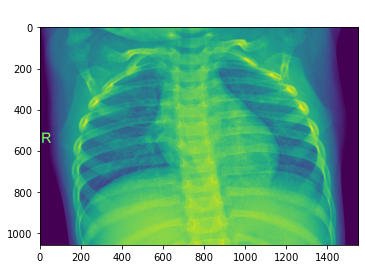

In [6]:
plt.title('NORMAL', fontsize=20, color='white')
plt.imshow(normal)
print(normal.shape) # print image size

# Data preprocessing

In [7]:
# ImageDataGenerator for training and test
datagen = ImageDataGenerator(validation_split = 0.25, 
                             rescale=1./255, 
                             rotation_range = 30, 
                             zoom_range = 0.15, 
                             width_shift_range=0.15, 
                             height_shift_range=0.15, 
                             horizontal_flip=False,
                             vertical_flip=False)
# ImageDataGenerator for val set
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
IMG_SIZE = (227, 227)
train_set = datagen.flow_from_directory(train_dir, 
                                        subset= 'training',
                                        class_mode='binary', 
                                        batch_size= 32,
                                        target_size=IMG_SIZE)

Found 3925 images belonging to 2 classes.


In [9]:
test_set = datagen.flow_from_directory(train_dir, 
                                        subset= 'validation',
                                        class_mode='binary', 
                                        batch_size= 32,
                                        target_size=IMG_SIZE)

Found 1307 images belonging to 2 classes.


In [10]:
X_train, y_train = train_set.next()
X_test, y_test = test_set.next()

In [11]:
print(len(X_train), len(y_train))

32 32


In [12]:
print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('Test X=%s Y=%s' %(X_test.shape, y_test.shape))

Train X=(32, 227, 227, 3) Y=(32,)
Test X=(32, 227, 227, 3) Y=(32,)


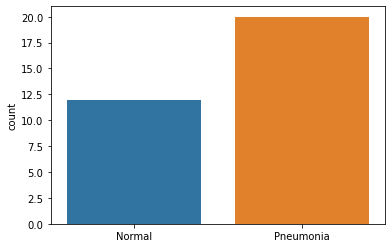

In [13]:


labels = ['Normal' if label == 0 else 'Pneumonia' for label in y_train]
sns.countplot(labels)

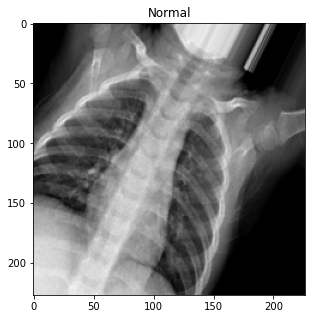

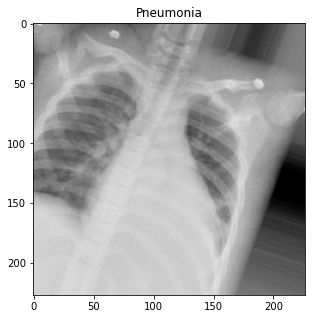

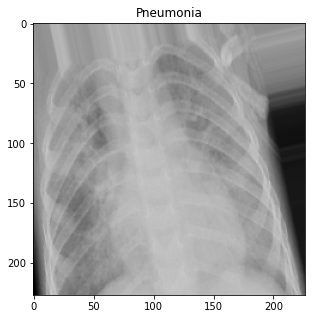

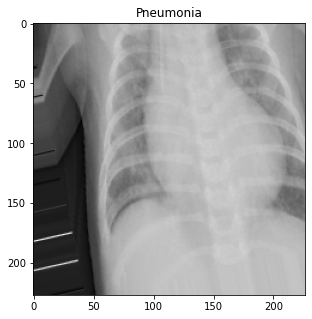

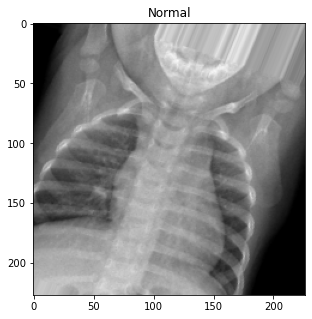

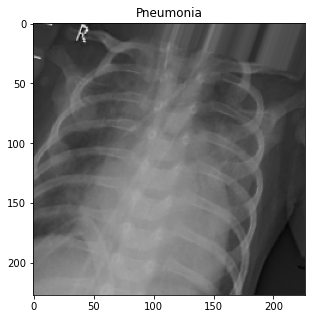

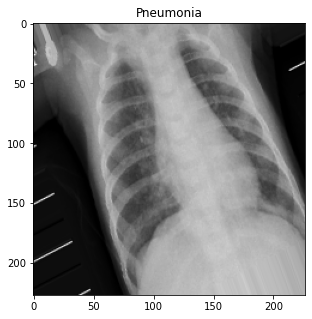

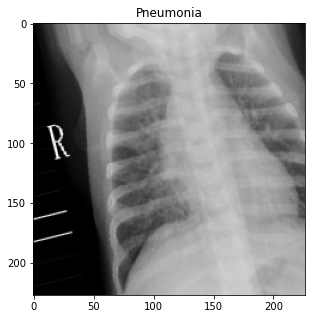

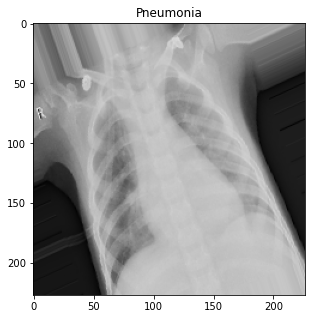

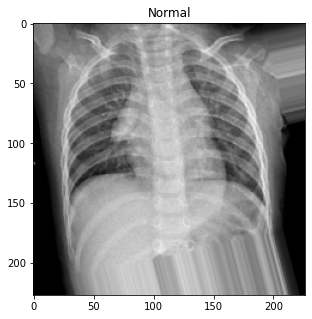

In [14]:
for idx in range(10):
    plt.figure(figsize=(5, 5))
    plt.imshow(X_train[idx])
    plt.title(labels[idx])

In [15]:
X_train[0].shape

(227, 227, 3)

# AlexNet CNN Architecture

In [16]:
# Create callbacks for our model

# Create checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('model_alex_net.h5') 

# Create Custom callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):
            if logs.get('accuracy') <= logs.get('val_accuracy'):
                self.model.stop_training = True
            else:
                self.model.stop_training = False
#             if(logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.94) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):

custom_cb = CustomCallback()

In [17]:
# Define alexNet model


model_alex_net = tf.keras.models.Sequential([
     # 1st conv layer                                        
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3),
                           padding='valid'),
    tf.keras.layers.BatchNormalization(),
    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),

    # 2nd conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),

    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    # 3rd conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 4th Conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 5th Conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # Max Pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
# Look at summary of our model
model_alex_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [19]:
model_alex_net.compile(loss='binary_crossentropy', optimizer =tf.optimizers.Adam(), metrics=['accuracy'])

In [20]:
hist = model_alex_net.fit(
    train_set,
    validation_data = test_set,
    epochs = 32,
    callbacks=[custom_cb, checkpoint_cb]
)

Epoch 1/32
123/123 [==============================] - 153s 1s/step - loss: 1.0823 - accuracy: 0.7707 - val_loss: 1.4859 - val_accuracy: 0.7422
Epoch 2/32
123/123 [==============================] - 118s 959ms/step - loss: 0.3887 - accuracy: 0.8464 - val_loss: 1.1771 - val_accuracy: 0.7437
Epoch 3/32
123/123 [==============================] - 109s 890ms/step - loss: 0.3198 - accuracy: 0.8716 - val_loss: 0.9026 - val_accuracy: 0.7636
Epoch 4/32
123/123 [==============================] - 110s 891ms/step - loss: 0.2986 - accuracy: 0.8790 - val_loss: 0.3790 - val_accuracy: 0.8424
Epoch 5/32
123/123 [==============================] - 109s 884ms/step - loss: 0.2920 - accuracy: 0.8879 - val_loss: 0.6384 - val_accuracy: 0.7965
Epoch 6/32
123/123 [==============================] - 109s 886ms/step - loss: 0.2449 - accuracy: 0.9034 - val_loss: 0.3777 - val_accuracy: 0.8569
Epoch 7/32
123/123 [==============================] - 109s 885ms/step - loss: 0.2046 - accuracy: 0.9210 - val_loss: 1.4662 - va

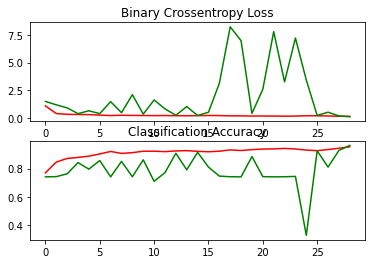

In [21]:
# Plot accuracy and loss


plt.subplot(211)
plt.title('Binary Crossentropy Loss')
plt.plot(hist.history['loss'], color ='red', label='train')
plt.plot(hist.history['val_loss'], color ='green', label='val')

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(hist.history['accuracy'], color='red', label='train')
plt.plot(hist.history['val_accuracy'], color='green', label='test')

plt.show()

# Make Predictions

In [22]:
# ImageDataGenerator for val set
val_datagen = ImageDataGenerator(rescale=1./255)

# Create val dataset
val_set = val_datagen.flow_from_directory(val_dir, 
                                          batch_size= 32, 
                                          target_size=IMG_SIZE, 
                                          class_mode='binary')
X_val, y_val = val_set.next()

Found 624 images belonging to 2 classes.


In [23]:
print('Loss of the model is - ', model_alex_net.evaluate(X_val, y_val)[0])
print('Accuracy of the model is - ', model_alex_net.evaluate(X_val, y_val)[1]*100, '%')

1/1 [==============================] - 0s 7ms/step - loss: 0.1320 - accuracy: 0.9062
Loss of the model is -  0.13202619552612305
1/1 [==============================] - 0s 7ms/step - loss: 0.1320 - accuracy: 0.9062
Accuracy of the model is -  90.625 %


In [24]:
predict = model_alex_net.predict_classes(X_val)
predict = predict.reshape(1, -1)[0]
predict

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

In [25]:
predict_test = model_alex_net.predict_classes(X_test)
predict_test = predict.reshape(1, -1)[0]
predict_test

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1], dtype=int32)

In [26]:

print(classification_report(y_val, predict, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.86      0.75      0.80         8
   Normal (Class 1)       0.92      0.96      0.94        24

           accuracy                           0.91        32
          macro avg       0.89      0.85      0.87        32
       weighted avg       0.90      0.91      0.90        32



In [27]:
print(classification_report(y_test, predict_test, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.43      0.38      0.40         8
   Normal (Class 1)       0.80      0.83      0.82        24

           accuracy                           0.72        32
          macro avg       0.61      0.60      0.61        32
       weighted avg       0.71      0.72      0.71        32



In [28]:
print('Confusion Matrix\n')
matrix = confusion_matrix(y_val, predict)
print(matrix)

Confusion Matrix

[[ 6  2]
 [ 1 23]]


In [29]:
correct = np.nonzero(predict == y_val)[0]
incorrect = np.nonzero(predict != y_val)[0]
print(len(correct), len(incorrect))

29 3


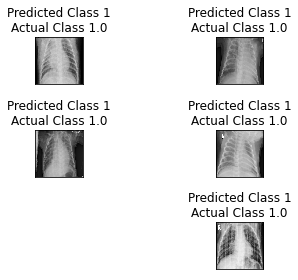

In [30]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predict[c], y_val[c]))
    plt.tight_layout()
    i += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


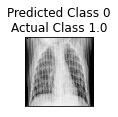

In [31]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_val[c], cmap="gray", interpolation='none')
    plt.title("Predicted Class {}\nActual Class {}".format(predict[c], y_val[c]))
    plt.tight_layout()

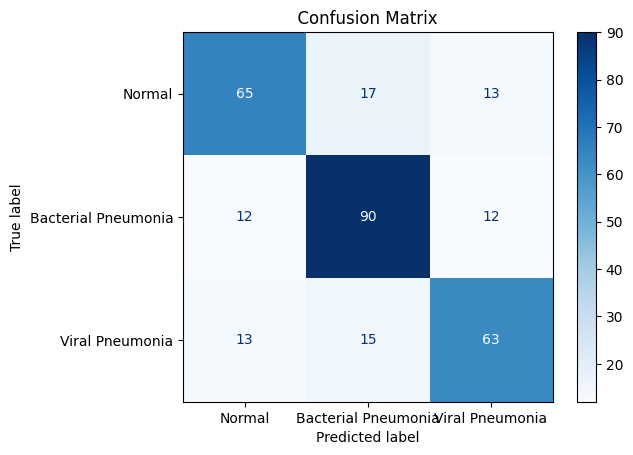

Classification Report:
                     precision    recall  f1-score   support

             Normal       0.74      0.79      0.76       114
Bacterial Pneumonia       0.72      0.68      0.70        95
    Viral Pneumonia       0.72      0.69      0.70        91

           accuracy                           0.73       300
          macro avg       0.73      0.72      0.72       300
       weighted avg       0.73      0.73      0.73       300



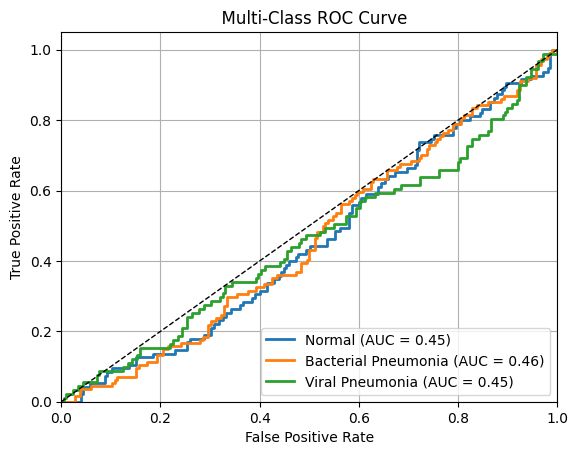

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize

# Class names
classes = ['Normal', 'Bacterial Pneumonia', 'Viral Pneumonia']
n_classes = len(classes)

#  y_true and y_pred are already defined, where:
y_true = [actual labels]
y_pred = [predicted labels]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(n_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

 
y_pred_prob = clf.predict_proba(X_test)  # Predicted probabilities for each class

# true labels for ROC calculation
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()
